In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

In [5]:
dataset_dir = Path('../datasets_secret')
templates_raw = pd.read_csv(dataset_dir / 'templates_w_nodes.csv')


# convert content to json
templates_raw['content_dict'] = templates_raw['content'].apply(json.loads)

templates_raw.head()

templates_raw.columns



Index(['prompt', 'used', 'createdAt', 'url', 'width', 'height', 'templateId',
       'presetConfigSlug', 'seed', 'negativePrompt', 'prompt_embedding',
       'url_jpeg', 'image_embedding', 'content', 'previewUrl',
       'promptSuggestions', 'id', 'title', 'used.1', 'userId', 'createdAt.1',
       'updatedAt', 'visibility', 'keywords', 'type', 'visibilityUpdatedAt',
       'visibilityUpdatedBy', 'source', 'content_dict'],
      dtype='object')

In [6]:
any_text_filter = lambda x: any(node['type'] == 'text' for node in x['nodes'])
any_image_filter = lambda x: any(node['type'] == 'image' for node in x['nodes'])
not_any_geo_filter = lambda x: not any(node['type'] == 'geo' for node in x['nodes'])

# Filter for templates with just images and text, and NEVER geo
templates_images_and_text = templates_raw[
    (templates_raw['content_dict'].apply(any_text_filter)
    | templates_raw['content_dict'].apply(any_image_filter))
    &
    templates_raw['content_dict'].apply(not_any_geo_filter)
]
num_templates = len(templates_images_and_text)
print(f"Number of templates: {num_templates}")

# Print a random template
random_template = templates_images_and_text.iloc[np.random.randint(0, num_templates)]
print(random_template.content)


Number of templates: 1322
{"nodes": [{"x": 221.7550073792955, "y": 816.360952983344, "id": "shape:anN79LErbQC3uvhxdrfcW", "fill": "#3C3C3C", "font": "'Alegreya', 'Alegreya Fallback'", "text": "“Growth takes time — like the sun rising, little by little.”", "type": "text", "angle": 0, "scale": 1.451224963103522, "width": 400, "height": 100, "opacity": 1, "fontSize": 64, "richText": {"type": "doc", "content": [{"type": "paragraph", "attrs": {"dir": "auto"}, "content": [{"text": "“Growth takes time — like the sun rising, little by little.”", "type": "text", "marks": [{"type": "textStyle", "attrs": {"color": "#3C3C3C", "fontSize": null}}]}]}]}, "fontStyle": "normal", "textAlign": "center", "fontWeight": "400", "lineHeight": 1, "letterSpacing": 0, "textDecoration": "none"}, {"x": 214.8462998102466, "y": 173.6925996204929, "id": "shape:fWFo7ioeoTvAZC42w6mM3", "url": "https://images.playground.com/f4675ec3-d206-4fcf-8836-0bad032567fb.png", "crop": null, "meta": {"model": "4o", "source": "ai-ge

Evaluating UI quality scores...
Scoring 1131w-02GXIIidf_4...
Scoring 1131w-50t2MzJLmsM...
Scoring 1131w-9cN5biKALLQ...
Scoring 1131w-Cn6h5Tqrn10...
Scoring 1131w-DBVzDPV0y5E...
Scoring 1131w-HeJuVR7Avb0...
Scoring 1131w-MQeKlmQ9RXc...
Scoring 1131w-Uq1C4aZZi9w...
Scoring 1131w-eRlpDg4f0K8...
Scoring 1131w-rH9o0IzDWQY...
Scoring 1131w-sSnAV2dB_qg...
Scoring 1131w-w-XME4y3KWk...
Scoring 1131w-zau150HLMWk...
Scoring 1131w-zsrhBwj_J58...
Scoring 1143w-ugSBoa9VtEw...
Scoring 1200w-taPfkpk_5cE...
Scoring 1257w-EN_LTZdAMlw...
Scoring 1257w-dnPJ18q1Q2E...
Scoring 1280w-1EsFpGQoTQo...
Scoring 1280w-7NdToF9SL00...
Scoring 1280w-GZEFZIEhLE0...
Scoring 1280w-IBJtTP4icf8...
Scoring 1280w-QVxrpF_dKgM...
Scoring 1600w-1HZYAUid2AE...
Scoring 1600w-3BBdsD4EXsY...
Scoring 1600w-4gpfnsQOREQ...
Scoring 1600w-7YZFYlcCTPk...
Scoring 1600w-9JTrLkx-Ppg...
Scoring 1600w-9eXC-dXI0uE...
Scoring 1600w-A9ARWpzo3xk...
Scoring 1600w-CxALar1xspQ...
Scoring 1600w-D3Vl-1x6STM...
Scoring 1600w-DB7VCKEjrvU...
Scoring 160

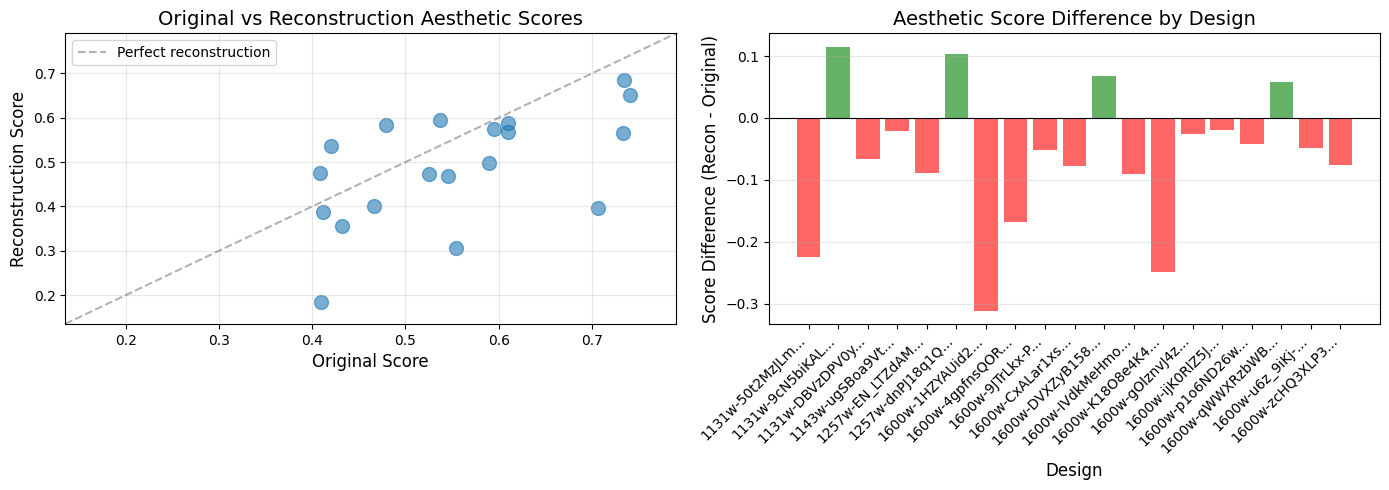


SUMMARY STATISTICS
Average Original Score:        0.5532
Average Reconstruction Score:  0.4894
Average Difference:            -0.0639

Best Reconstruction:  1600w-u6z_9iKj-iQ
  Score: 0.6857

Worst Reconstruction: 1131w-50t2MzJLmsM
  Score: 0.1852


In [7]:
# Evaluate UI quality scores for originals and reconstructions
import sys
sys.path.append('..')
from lib.uiclip import score_image
import matplotlib.pyplot as plt

canva_dir = Path('../datasets/canva')
reconstructions_dir = Path('../datasets/reconstructions')

print("Evaluating UI quality scores...")

# Get all original Canva images
canva_images = sorted(canva_dir.glob('*.webp'))

results = []

for img_path in canva_images:
    design_name = img_path.stem
    
    print(f"Scoring {design_name}...")
    
    # Score original
    original_score = score_image(img_path, description="graphic design")
    
    # Score reconstruction if it exists
    reconstruction_path = reconstructions_dir / design_name / "render.png"
    if reconstruction_path.exists():
        reconstruction_score = score_image(reconstruction_path, description="graphic design")
        
        results.append({
            'name': design_name,
            'original': original_score,
            'reconstruction': reconstruction_score,
            'diff': reconstruction_score - original_score
        })

# Convert to DataFrame
df_scores = pd.DataFrame(results)
print(f"\n{df_scores}")

# Plot comparison
if len(df_scores) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Original vs Reconstruction
    ax1 = axes[0]
    ax1.scatter(df_scores['original'], df_scores['reconstruction'], s=100, alpha=0.6)
    
    # Add diagonal line (perfect reconstruction)
    lims = [
        min(df_scores['original'].min(), df_scores['reconstruction'].min()) - 0.05,
        max(df_scores['original'].max(), df_scores['reconstruction'].max()) + 0.05,
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.3, label='Perfect reconstruction')
    
    ax1.set_xlabel('Original Score', fontsize=12)
    ax1.set_ylabel('Reconstruction Score', fontsize=12)
    ax1.set_title('Original vs Reconstruction Aesthetic Scores', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    # Bar plot: Difference by design
    ax2 = axes[1]
    colors = ['green' if d >= 0 else 'red' for d in df_scores['diff']]
    ax2.bar(range(len(df_scores)), df_scores['diff'], color=colors, alpha=0.6)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    ax2.set_xlabel('Design', fontsize=12)
    ax2.set_ylabel('Score Difference (Recon - Original)', fontsize=12)
    ax2.set_title('Aesthetic Score Difference by Design', fontsize=14)
    ax2.set_xticks(range(len(df_scores)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_scores['name']], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Average Original Score:        {df_scores['original'].mean():.4f}")
    print(f"Average Reconstruction Score:  {df_scores['reconstruction'].mean():.4f}")
    print(f"Average Difference:            {df_scores['diff'].mean():+.4f}")
    print(f"\nBest Reconstruction:  {df_scores.loc[df_scores['reconstruction'].idxmax(), 'name']}")
    print(f"  Score: {df_scores['reconstruction'].max():.4f}")
    print(f"\nWorst Reconstruction: {df_scores.loc[df_scores['reconstruction'].idxmin(), 'name']}")
    print(f"  Score: {df_scores['reconstruction'].min():.4f}")


Evaluating aesthetic scores with Gemini (parallel)...
✓ 1131w-MQeKlmQ9RXc: 93.0 → 92.0 (diff: -1.0)
✓ 1131w-Uq1C4aZZi9w: 92.0 → 45.0 (diff: -47.0)
✓ 1131w-eRlpDg4f0K8: 82.0 → 22.0 (diff: -60.0)
✓ 1131w-DBVzDPV0y5E: 72.0 → 25.0 (diff: -47.0)
✓ 1131w-HeJuVR7Avb0: 88.0 → 85.0 (diff: -3.0)
✓ 1131w-9cN5biKALLQ: 85.0 → 25.0 (diff: -60.0)
✓ 1131w-50t2MzJLmsM: 84.0 → 42.0 (diff: -42.0)
✓ 1131w-rH9o0IzDWQY: 64.0 → 75.0 (diff: +11.0)
✓ 1131w-Cn6h5Tqrn10: 88.0 → 45.0 (diff: -43.0)
✓ 1200w-taPfkpk_5cE: 88.0 → 12.0 (diff: -76.0)
✓ 1131w-02GXIIidf_4: 90.0 → 38.0 (diff: -52.0)
✓ 1131w-sSnAV2dB_qg: 92.0 → 62.0 (diff: -30.0)
✓ 1131w-w-XME4y3KWk: 92.0 → 68.0 (diff: -24.0)
✓ 1280w-1EsFpGQoTQo: 91.0 → 82.0 (diff: -9.0)
✓ 1257w-EN_LTZdAMlw: 92.0 → 42.0 (diff: -50.0)
✓ 1131w-zsrhBwj_J58: 92.0 → 76.0 (diff: -16.0)
✓ 1131w-zau150HLMWk: 92.0 → 62.0 (diff: -30.0)
✓ 1143w-ugSBoa9VtEw: 88.0 → 70.0 (diff: -18.0)
✓ 1257w-dnPJ18q1Q2E: 88.0 → 83.0 (diff: -5.0)
✓ 1280w-GZEFZIEhLE0: 92.0 → 84.0 (diff: -8.0)
✓ 1600w-7YZ

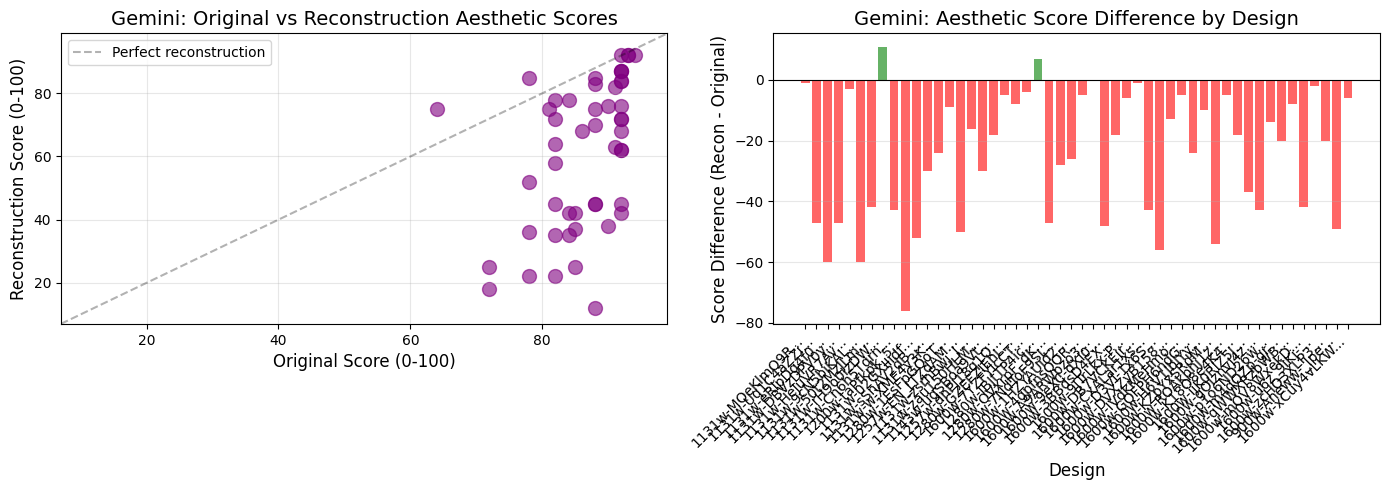


GEMINI SUMMARY STATISTICS
Average Original Score:        86.28
Average Reconstruction Score:  61.18
Average Difference:            -25.10

Best Reconstruction:  1131w-MQeKlmQ9RXc
  Score: 92.00

Worst Reconstruction: 1200w-taPfkpk_5cE
  Score: 12.00


In [4]:
# Evaluate aesthetic scores using Gemini (parallelized)
from lib.ai import gemini_score_aesthetic
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

canva_dir = Path('../datasets/canva')
reconstructions_dir = Path('../datasets/reconstructions')

print("Evaluating aesthetic scores with Gemini (parallel)...")

# Get all original Canva images
canva_images = sorted(canva_dir.glob('*.webp'))

results_gemini = []

def score_pair(img_path):
    """Score both original and reconstruction for a design."""
    design_name = img_path.stem
    
    # Score original
    original_score = gemini_score_aesthetic(img_path)
    
    # Score reconstruction if it exists
    reconstruction_path = reconstructions_dir / design_name / "render.png"
    reconstruction_score = None
    if reconstruction_path.exists():
        reconstruction_score = gemini_score_aesthetic(reconstruction_path)
    
    return {
        'name': design_name,
        'original': original_score,
        'reconstruction': reconstruction_score,
        'diff': reconstruction_score - original_score if reconstruction_score else None
    }

# Use ThreadPoolExecutor to parallelize API calls
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(score_pair, img_path): img_path for img_path in canva_images}
    
    for future in as_completed(futures):
        img_path = futures[future]
        try:
            result = future.result()
            if result['reconstruction'] is not None:
                results_gemini.append(result)
                print(f"✓ {result['name']}: {result['original']:.1f} → {result['reconstruction']:.1f} (diff: {result['diff']:+.1f})")
        except Exception as e:
            print(f"✗ {img_path.stem}: Error - {e}")

# Convert to DataFrame
df_gemini = pd.DataFrame(results_gemini)
print(f"\n{df_gemini}")

# Plot comparison
if len(df_gemini) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Original vs Reconstruction
    ax1 = axes[0]
    ax1.scatter(df_gemini['original'], df_gemini['reconstruction'], s=100, alpha=0.6, color='purple')
    
    # Add diagonal line (perfect reconstruction)
    lims = [
        min(df_gemini['original'].min(), df_gemini['reconstruction'].min()) - 5,
        max(df_gemini['original'].max(), df_gemini['reconstruction'].max()) + 5,
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.3, label='Perfect reconstruction')
    
    ax1.set_xlabel('Original Score (0-100)', fontsize=12)
    ax1.set_ylabel('Reconstruction Score (0-100)', fontsize=12)
    ax1.set_title('Gemini: Original vs Reconstruction Aesthetic Scores', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    # Bar plot: Difference by design
    ax2 = axes[1]
    colors = ['green' if d >= 0 else 'red' for d in df_gemini['diff']]
    ax2.bar(range(len(df_gemini)), df_gemini['diff'], color=colors, alpha=0.6)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    ax2.set_xlabel('Design', fontsize=12)
    ax2.set_ylabel('Score Difference (Recon - Original)', fontsize=12)
    ax2.set_title('Gemini: Aesthetic Score Difference by Design', fontsize=14)
    ax2.set_xticks(range(len(df_gemini)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_gemini['name']], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print("\n" + "="*60)
    print("GEMINI SUMMARY STATISTICS")
    print("="*60)
    print(f"Average Original Score:        {df_gemini['original'].mean():.2f}")
    print(f"Average Reconstruction Score:  {df_gemini['reconstruction'].mean():.2f}")
    print(f"Average Difference:            {df_gemini['diff'].mean():+.2f}")
    print(f"\nBest Reconstruction:  {df_gemini.loc[df_gemini['reconstruction'].idxmax(), 'name']}")
    print(f"  Score: {df_gemini['reconstruction'].max():.2f}")
    print(f"\nWorst Reconstruction: {df_gemini.loc[df_gemini['reconstruction'].idxmin(), 'name']}")
    print(f"  Score: {df_gemini['reconstruction'].min():.2f}")

In [5]:
# Worst 4 regressions and best 4 performers (Gemini eval)
from IPython.display import display

if 'df_gemini' not in globals() or df_gemini is None or len(df_gemini) == 0:
    print("No Gemini eval results available (df_gemini is empty). Run the Gemini eval cell above first.")
else:
    cols = ['name', 'original', 'reconstruction', 'diff']
    worst_4 = df_gemini.nsmallest(4, 'diff')[cols].copy()
    best_4  = df_gemini.nlargest(4, 'diff')[cols].copy()

    # Round for readability
    for c in ['original', 'reconstruction', 'diff']:
        worst_4[c] = worst_4[c].round(1)
        best_4[c]  = best_4[c].round(1)

    print("Worst 4 regressions (most negative diff):")
    display(worst_4.reset_index(drop=True))

    print("\nBest 4 performers (most positive diff):")
    display(best_4.reset_index(drop=True))


Worst 4 regressions (most negative diff):


,name,original,reconstruction,diff
0,1200w-taPfkpk_5cE,88.0,12.0,-76.0
1,1131w-eRlpDg4f0K8,82.0,22.0,-60.0
2,1131w-9cN5biKALLQ,85.0,25.0,-60.0
3,1600w-D3Vl-1x6STM,78.0,22.0,-56.0



Best 4 performers (most positive diff):


,name,original,reconstruction,diff
0,1131w-rH9o0IzDWQY,64.0,75.0,11.0
1,1280w-IBJtTP4icf8,78.0,85.0,7.0
2,1600w-A9ARWpzo3xk,92.0,92.0,0.0
3,1131w-MQeKlmQ9RXc,93.0,92.0,-1.0


In [ ]:
# Inline render worst 4 regressions and best 4 performers (Gemini eval)
from IPython.display import display, HTML
from pathlib import Path
from io import BytesIO
from PIL import Image
import base64

canva_dir = Path('../datasets/canva')
reconstructions_dir = Path('../datasets/reconstructions')

def _to_data_url(path: Path) -> str:
    with Image.open(path) as im:
        im = im.convert('RGBA') if im.mode in ('P', 'LA') else im.convert('RGB')
        buf = BytesIO()
        im.save(buf, format='PNG')
        b64 = base64.b64encode(buf.getvalue()).decode('ascii')
        return f'data:image/png;base64,{b64}'

def _find_reconstruction(name: str) -> Path | None:
    p1 = reconstructions_dir / name / 'render.png'
    if p1.exists():
        return p1
    p2 = reconstructions_dir / f'{name}.png'
    if p2.exists():
        return p2
    return None

def _render_grid(df, title: str):
    rows = []
    for _, row in df.iterrows():
        name = row['name']
        orig = canva_dir / f'{name}.webp'
        recon = _find_reconstruction(name)
        if not orig.exists() or recon is None or not recon.exists():
            continue
        try:
            orig_url = _to_data_url(orig)
            recon_url = _to_data_url(recon)
        except Exception:
            # If conversion fails, skip this entry
            continue
        rows.append(f"""
        <div style='display:flex;gap:24px;margin-bottom:24px;align-items:flex-start;'>
          <div style='flex:1;'>
            <div style='font:12px/1.2 monospace;opacity:0.7;'>{name} — original ({row['original']:.1f})</div>
            <img src='{orig_url}' style='max-width:100%;width:320px;border:1px solid #ddd;border-radius:6px' />
          </div>
          <div style='flex:1;'>
            <div style='font:12px/1.2 monospace;opacity:0.7;'>reconstruction ({row['reconstruction']:.1f}) — diff {row['diff']:+.1f}</div>
            <img src='{recon_url}' style='max-width:100%;width:320px;border:1px solid #ddd;border-radius:6px' />
          </div>
        </div>
        """)
    html = f"""
    <h3 style='margin:8px 0'>{title}</h3>
    <div>{''.join(rows) if rows else '<em>No images available.</em>'}</div>
    """
    display(HTML(html))

# Ensure we have worst_4 / best_4; if not, compute from df_gemini
if 'df_gemini' in globals() and len(df_gemini) > 0:
    if 'worst_4' not in globals() or 'best_4' not in globals():
        cols = ['name', 'original', 'reconstruction', 'diff']
        worst_4 = df_gemini.nsmallest(4, 'diff')[cols].copy()
        best_4  = df_gemini.nlargest(4, 'diff')[cols].copy()
        for c in ['original', 'reconstruction', 'diff']:
            worst_4[c] = worst_4[c].round(1)
            best_4[c]  = best_4[c].round(1)
    _render_grid(worst_4, 'Worst 4 regressions (Gemini)')
    _render_grid(best_4, 'Best 4 performers (Gemini)')
else:
    print('df_gemini is empty. Run the Gemini eval cell first.')
